# IMDB Sentiment Classifier -Convolutional

#### Load dependencies

In [4]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,  Flatten, Dropout, Conv1D, GlobalMaxPooling1D, SpatialDropout1D
from keras.layers import Embedding 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\moi\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Set Hyperparameters 

In [5]:
output_dir='model_output/conv'

epochs=4
batch_size=128 #mini b.s. for Gradient Descent, for start

# for Vector Space Embeddings: 

n_dim=64 # number of dimensions
n_unique_words = 5000
n_words_to_skip= 50 # the most common word, skip the top 50
max_review_length =400 # if review has more than 100 words: truncate; the longer the review = longer train &...

drop_embed=0.2  #dropout into the embedding layer, to randomly dropout 20%; to avoid overfitting
pad_type=  trunc_type='pre' # what kind of padding / truncating'



#### NN architecture 

In [6]:
n_dense=256
dropout=0.2

n_conv = 256 # nr of kernels in the conv. layer
k_conv=3  # size of the filter, here: 1-dimensional; sequences of 3 words in a row

#### Load data 

in one line: 
* set the max. number of tokens in each of documents, 
* filters out punctuation, 
* sets all tokens to lowercase, 
* converts all words into an integer index
<br>
= keras.preprocessing.text.Tokenizer

In [7]:
(X_train, y_train), (X_test, y_test) =  imdb.load_data(num_words=n_unique_words)
                                #no skipped words, they can be important)

#### Restore words from index 

In [8]:
word_index=keras.datasets.imdb.get_word_index()
word_index={k:(v+3) for k,v in word_index.items()}
word_index['PAD']=0
word_index['START']=1
word_index['UNK']=2

In [9]:
word_index={v:k for k,v in word_index.items()}
word_index[215]

'must'

In [10]:

(w_x_train,_), (w_x_valid,_)=imdb.load_data()

#### Preprocess data 
we dediced that sequences longer than 100 will bo truncated to 100 tokens
and if shorter than 100: will be padded up to 100<br>
we truncate the front of the reviews away
<br> and we take the value of 0 for our padding

In [11]:
X_train=pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type)
X_test=pad_sequences(X_test, maxlen=max_review_length, padding=pad_type, truncating=trunc_type)

#### Design NN architecture

In [13]:
model=Sequential()
model.add(Embedding(n_unique_words, # creating Vector Space from text, in a single step
                  n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed)) # dropout to the embedding layer; 20% of the neurons
model.add(Conv1D (n_conv, k_conv, activation='relu'))
    # no need for model.add(Flatten()) 
model.add(GlobalMaxPooling1D()) # reduce the dimensionality 
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid')) # 2 classes, = sigmoid neuron is ok

reviews fitted into embedding layer, which converts the language into **vector space embedding**
<br>Dense layer will learn which word vector representations are predictive of whether it is a positive or negative review


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 400, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total para

fewer parameters, we had 700 000 in dense l., here only 400 000 <br>
= the efficiency of the convolutional layers, more dense calculations then dense layers

#### Configure the model 

In [15]:
model.compile(
    loss='binary_crossentropy',    #what kind of loss we are going to have, this is v. efficient
                                   # przy MNIST był categorical_crossentropy - for multiclass problems    
    optimizer='adam',
    metrics=['accuracy'])  

In [16]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [17]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train

In [34]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 150s 6ms/step - loss: 0.4922 - acc: 0.7402 - val_loss: 0.2957 - val_acc: 0.8743
Epoch 2/4
25000/25000 [==============================] - 142s 6ms/step - loss: 0.2533 - acc: 0.8983 - val_loss: 0.2547 - val_acc: 0.8948
Epoch 3/4
25000/25000 [==============================] - 148s 6ms/step - loss: 0.1676 - acc: 0.9380 - val_loss: 0.2628 - val_acc: 0.8940
Epoch 4/4
25000/25000 [==============================] - 156s 6ms/step - loss: 0.1133 - acc: 0.9610 - val_loss: 0.2839 - val_acc: 0.8940


#### Evaluate 

In [22]:
model.load_weights(output_dir+'/weights.01.hdf5') 

In [23]:
y_hat=model.predict_proba(X_test)

In [24]:
y_hat[1]

array([0.9775009], dtype=float32)

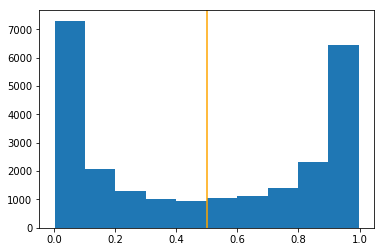

In [25]:
plt.hist(y_hat)
_=plt.axvline(x=0.5, color='orange')


In [26]:
pct_auc=roc_auc_score(y_test, y_hat)*100
pct_auc

94.74083264

In [27]:
'{:0.2f}'.format(pct_auc)

'94.74'

In [28]:
float_y_hat=[]
for i in y_hat:
    float_y_hat.append(i[0])

In [29]:
a=list(y_hat)

In [30]:
ydf=pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])

In [31]:
ydf.head(20)

,y_hat,y
0,0.054683,0
1,0.977501,1
2,0.656250,1
3,0.468559,0
4,0.978763,1
5,0.732258,1
6,0.907474,1
7,0.046727,0
8,0.950421,0
9,0.848194,1


review with best score:

In [32]:
' '.join(word_index[id] for id in w_x_valid[14])

'START a touching documentary that puts a human face on the tragedy of 9 11 by showing how one small community to honor two high school friends lost on that day the film interweaves the lives of chris and tom through interviews with family and friends and snippets of old photos through their reminiscences we glimpse two lives tragically cut short the film also documents how through a series of coincidences an inspirational memorial garden was brought forth through the efforts of many people both known and unknown to the two victims through the laughter and the tears and the sweat we see the power of hope and honor and love this films evokes many different emotions but the final feeling is one of admiration of the human spirit by tragedy'

the misclassified reviews 

In [33]:
wrongs=ydf[(ydf.y==0)&(ydf.y_hat>0.9)]

In [34]:
len(wrongs)

173

In [35]:
wrongs.head()

,y_hat,y
8,0.950421,0
299,0.959358,0
558,0.967919,0
814,0.900404,0
955,0.907248,0


In [37]:
' '.join(word_index[id] for id in w_x_valid[558])

"START first off i am a huge fan of tolkien and as one i will base most of my critic on his books br br the movie is a standard adventure movie well made with nifty special effects nice sound track and fine acting now if this movie was called something else than lord of the rings the reviews wouldn't be half this good as they are here br br the problem of the movie is that it takes the basic story line from tolkiens books but then it goes and hollywoods everything it can numerous scenes from the book are missing or changed quite a lot the characters are changed from the book also a thing that i think should be punishable what the movie lacks is deep insight of the characters in it i know that it is almost impossible to make a good film out of a good book and it didn't work here mostly the motivation of the characters is left hazy at best br br as a adventure movie it would rate 7 10 as a adaptation of tolkien it rates 2 10 br br i mean honestly what on earth was arwen doing at rivendel

In [38]:
fp=ydf[(ydf.y==1)&(ydf.y_hat<0.1)]

In [39]:
len(fp)

201

In [40]:
fp.head()

,y_hat,y
100,0.063347,1
333,0.080161,1
459,0.098273,1
466,0.091199,1
535,0.088928,1


... and:

In [43]:
' '.join(word_index[id] for id in w_x_valid[100])

"START a quick glance at the premise of this film would seem to indicate just another dumb '80's inbred backwood slash fest the type where sex equals death and the actors are all annoying stereotypes you actually want to die however delivers considerably more br br rather than focus on bare flesh and gore though there is a little of each no sex however the flick focuses on delivering impending dread mounting tension amidst a lovely scenic backdrop these feelings are further heightened by a cast of realistically likable characters and antagonists that are more amoral than cardboard definitions of evil oh yeah george kennedy is here too and when is that not a good thing br br if you liked wrong turn then watch this to see where much of its' methodology came from"